# Data Preprocessing
#### This notebook shows the process to extract the ppg, ecg, and blood pressure (abp) data from the .mat file, convert the data to time series and put them into a dataloader for training the LSTM. A training demo is also included to show that the dataloader works.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
import os

import torch
import torch.nn as nn

In [103]:
# !!!! If you want to run this notebook, change the file path
file_path = "G:/PycharmProjects/APS360Project/data/Part_1.mat"
# Open the .mat file using h5py.File()
with h5py.File(file_path, "r") as hdf_file:
    # List all the top-level keys (datasets, groups) in the HDF5 file
    ref_key = list(hdf_file.keys())[0]
    value_key = list(hdf_file.keys())[1]

    data = hdf_file[value_key]
    data = data[:200,0]

    numpy_data = []

    for i in range(data.shape[0]):
        person = data[i]
        obj = hdf_file[person]
        obj = obj[:]
        if obj.shape[0] > 5000:
            obj = obj[1000:4000]    #take 3000 data points for each subject
            numpy_data.append(obj)
        if len(numpy_data) >84:    #take the first 84 subjects
            break

Note that the first 84 subjects' data are used. 3000 data points are selected from the middle.

In [104]:
#convert numpy_data to numpy array
numpy_data = np.array(numpy_data)
#ppg_ecg is the 0th and 2nd channel
ppg = numpy_data[:,:,0]
ecg = numpy_data[:,:,2]
ppg_ecg = np.stack((ppg, ecg), axis=2)
abp = numpy_data[:,:,1]

I believe that in the paper, or at least in the repo that tried to replicate the paper's work, train test split are done on the subject level.

In [105]:
train_per = int(abp.shape[0] * 80 / 100)
val_per = int(abp.shape[0] * 20 / 100)
print('Num training set: ', train_per)
print('Num testing set:  ', val_per)

Num training set:  68
Num testing set:   17


In [106]:
X_main, X_test, y_main, y_test = ppg_ecg[val_per:], ppg_ecg[:val_per], abp[val_per:], abp[:val_per]

save the data to numpy file

In [107]:
folder_path = 'G:/PycharmProjects/APS360Project/data/'

np.save(folder_path+'x_main.npy', X_main)
np.save(folder_path+'y_main.npy', y_main)
np.save(folder_path+'x_test.npy', X_test)
np.save(folder_path+'y_test.npy', y_test)

In [3]:
X_train = np.load(folder_path+'x_main.npy',allow_pickle=True)
y_train = np.load(folder_path+'y_main.npy',allow_pickle=True)
X_test = np.load(folder_path+'x_test.npy',allow_pickle=True)
y_test = np.load(folder_path+'y_test.npy',allow_pickle=True)

In [4]:
X_train.shape

(68, 3000, 2)

In [5]:
def convert_to_2d(arr, index=None):
    array = []
    if index != None:
        for subject_index in range(arr.shape[0]):
            array.extend(arr[subject_index][:,index])
    else:
        for subject_index in range(arr.shape[0]):
            array.extend(arr[subject_index])
    return np.array(array)

Basically concatenate all the data together

In [6]:
ppg_train_conv = convert_to_2d(X_train, 0)
ecg_train_conv = convert_to_2d(X_train, 1)
abp_train_conv = convert_to_2d(y_train)

Normalize the data

In [9]:
#max min scaleing without using sklearn
ppg_train_conv_scaled = (ppg_train_conv - ppg_train_conv.min())/(ppg_train_conv.max()-ppg_train_conv.min())
ecg_train_conv_scaled = (ecg_train_conv - ecg_train_conv.min())/(ecg_train_conv.max()-ecg_train_conv.min())
abp_train_conv_scaled = (abp_train_conv - abp_train_conv.min())/(abp_train_conv.max()-abp_train_conv.min())

In [7]:
#write a function to convert ppg_train_conv to time series, with batch size of 32
def convert_to_timeseries(arr, batch_size):
    array = []
    i = 0
    while i < arr.shape[0]-batch_size:
        if (i+batch_size+2) % 3000 == 0:
            i +=36
            continue
            #skip the next 34 rounds

        array.append(arr[i:i+batch_size])
        i+=1
    return np.array(array)

Convert the data to time series. Basically the first row is data points 1-31, the second row is data points 2-32, etc.

In [10]:
#convert to time series\
ppg_train_timeseries_scaled = convert_to_timeseries(ppg_train_conv_scaled, 32)
ecg_train_timeseries_scaled = convert_to_timeseries(ecg_train_conv_scaled, 32)
abp_train_timeseries_scaled = convert_to_timeseries(abp_train_conv_scaled, 32)


In [132]:
print(ppg_train_timeseries_scaled.shape)
ppg_train_timeseries_scaled

(201554, 32)


array([[0.07352223, 0.07278945, 0.07181241, ..., 0.17269174, 0.17464582,
        0.17586712],
       [0.07278945, 0.07181241, 0.07107963, ..., 0.17464582, 0.17586712,
        0.17611138],
       [0.07181241, 0.07107963, 0.07034685, ..., 0.17586712, 0.17611138,
        0.1753786 ],
       ...,
       [0.43429409, 0.42647777, 0.4184172 , ..., 0.2691744 , 0.26722032,
        0.2655105 ],
       [0.42647777, 0.4184172 , 0.41011236, ..., 0.26722032, 0.2655105 ,
        0.26404494],
       [0.4184172 , 0.41011236, 0.40156326, ..., 0.2655105 , 0.26404494,
        0.26282364]])

see how the second row is just moving first row to the left by 1

In [13]:
#put ppg and ecg together to form the encoder input with shape (201554,32,2)
encoder_input = np.stack((ppg_train_timeseries_scaled, ecg_train_timeseries_scaled), axis=2)

#stack the abp as well to form the decoder output with shape (201554,32,1)
decoder_output = np.expand_dims(abp_train_timeseries_scaled, axis=2)


In [14]:
decoder_output.shape

(201554, 32, 1)

In [16]:
#get a dataloader with batch size of 128
from torch.utils.data import TensorDataset, DataLoader
train_data = TensorDataset(torch.from_numpy(encoder_input).float(), torch.from_numpy(decoder_output).float())
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

#### The data preprocessing is finished.
---------------------------------------------------------------------------
Here is a training demo to show that the data loader is working.

Used Haroon's LSTM class

In [15]:
class lstm_model(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(lstm_model, self).__init__()

        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=layer_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [104]:
model_untrained = lstm_model(2, 64, 3, 1)   #not trained, for comparison
model_trained = lstm_model(2, 64, 3, 1)

Not sure if I did it the right way but I was trying to make the model relatively complex and see if it can overfit the data and predict the training data well.

In [105]:
#train on gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_trained.to(device)
model_untrained.to(device)

lstm_model(
  (lstm): LSTM(2, 64, num_layers=3, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

In [106]:
#use dataloader to train the model
import torch.optim as optim
criterion = nn.MSELoss()
optimizer = optim.Adam(model_trained.parameters(), lr=0.0003)
#train the model
num_epochs = 40
loss_curve = []
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model_trained(inputs)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        if (i+1) % 100 == 0:
            print('Epoch: {}/{}, Step: {}/{}, Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))
            loss_curve.append(loss.item())


Epoch: 1/40, Step: 100/1575, Loss: 0.0360
Epoch: 1/40, Step: 200/1575, Loss: 0.0351
Epoch: 1/40, Step: 300/1575, Loss: 0.0311
Epoch: 1/40, Step: 400/1575, Loss: 0.0311
Epoch: 1/40, Step: 500/1575, Loss: 0.0303
Epoch: 1/40, Step: 600/1575, Loss: 0.0260
Epoch: 1/40, Step: 700/1575, Loss: 0.0259
Epoch: 1/40, Step: 800/1575, Loss: 0.0257
Epoch: 1/40, Step: 900/1575, Loss: 0.0242
Epoch: 1/40, Step: 1000/1575, Loss: 0.0245
Epoch: 1/40, Step: 1100/1575, Loss: 0.0217
Epoch: 1/40, Step: 1200/1575, Loss: 0.0259
Epoch: 1/40, Step: 1300/1575, Loss: 0.0287
Epoch: 1/40, Step: 1400/1575, Loss: 0.0255
Epoch: 1/40, Step: 1500/1575, Loss: 0.0240
Epoch: 2/40, Step: 100/1575, Loss: 0.0227
Epoch: 2/40, Step: 200/1575, Loss: 0.0222
Epoch: 2/40, Step: 300/1575, Loss: 0.0253
Epoch: 2/40, Step: 400/1575, Loss: 0.0241
Epoch: 2/40, Step: 500/1575, Loss: 0.0228
Epoch: 2/40, Step: 600/1575, Loss: 0.0197
Epoch: 2/40, Step: 700/1575, Loss: 0.0215
Epoch: 2/40, Step: 800/1575, Loss: 0.0311
Epoch: 2/40, Step: 900/1575,

Text(0.5, 1.0, 'training curve')

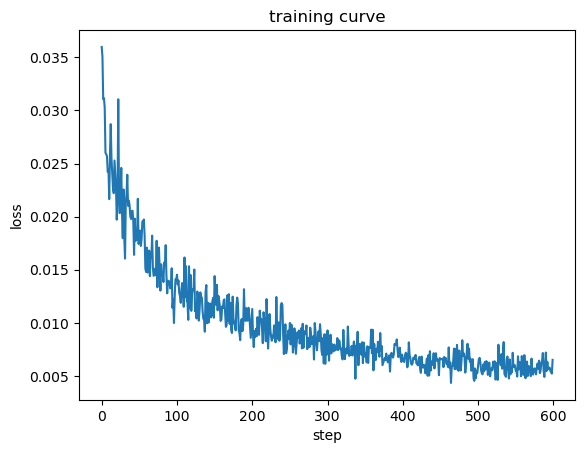

In [108]:
#plot the loss curve
plt.plot(loss_curve)
plt.xlabel('step')
plt.ylabel('loss')
plt.title('training curve')

In [109]:
output_trained = model_trained(torch.from_numpy(encoder_input[0:1280]).to(device).float())
output_untrained = model_untrained(torch.from_numpy(encoder_input[0:1280]).to(device).float())

In [133]:
output_trained.shape

torch.Size([1280, 32, 1])

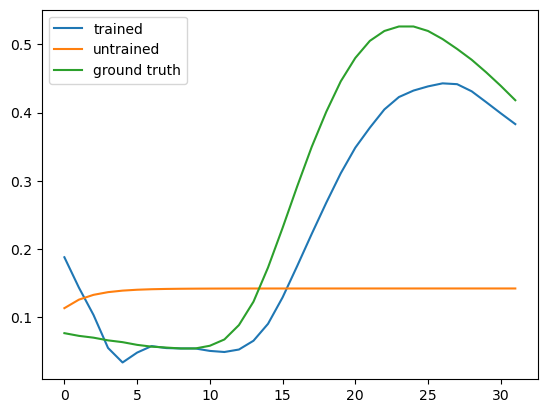

In [110]:
#compare the trained and untrained one to the ground truth
plt.plot(output_trained.cpu().detach().numpy()[50,:,0], label='trained')
plt.plot(output_untrained.cpu().detach().numpy()[50,:,0], label='untrained')
plt.plot(decoder_output[50,:,0], label='ground truth')
plt.legend()

It can be seen that in this batch, the training is working. Then we're converting the time series output back to 1d. The output structure is the same as the time series input, so like how we converted the input data to time series, we're converting the output time series back to 1d.

In [111]:
#convert the time series output back to 1d
def convert_to_1d(arr):
    array = []
    for i in range(arr.shape[0]):
        if i == 0:
            array.extend(arr[i,:,0])
        else:
            array.extend(arr[i,-1:,0])
    return np.array(array)

In [112]:
output_trained_1d = convert_to_1d(output_trained.cpu().detach().numpy())


In [113]:
output_trained_1d.shape

(1311,)

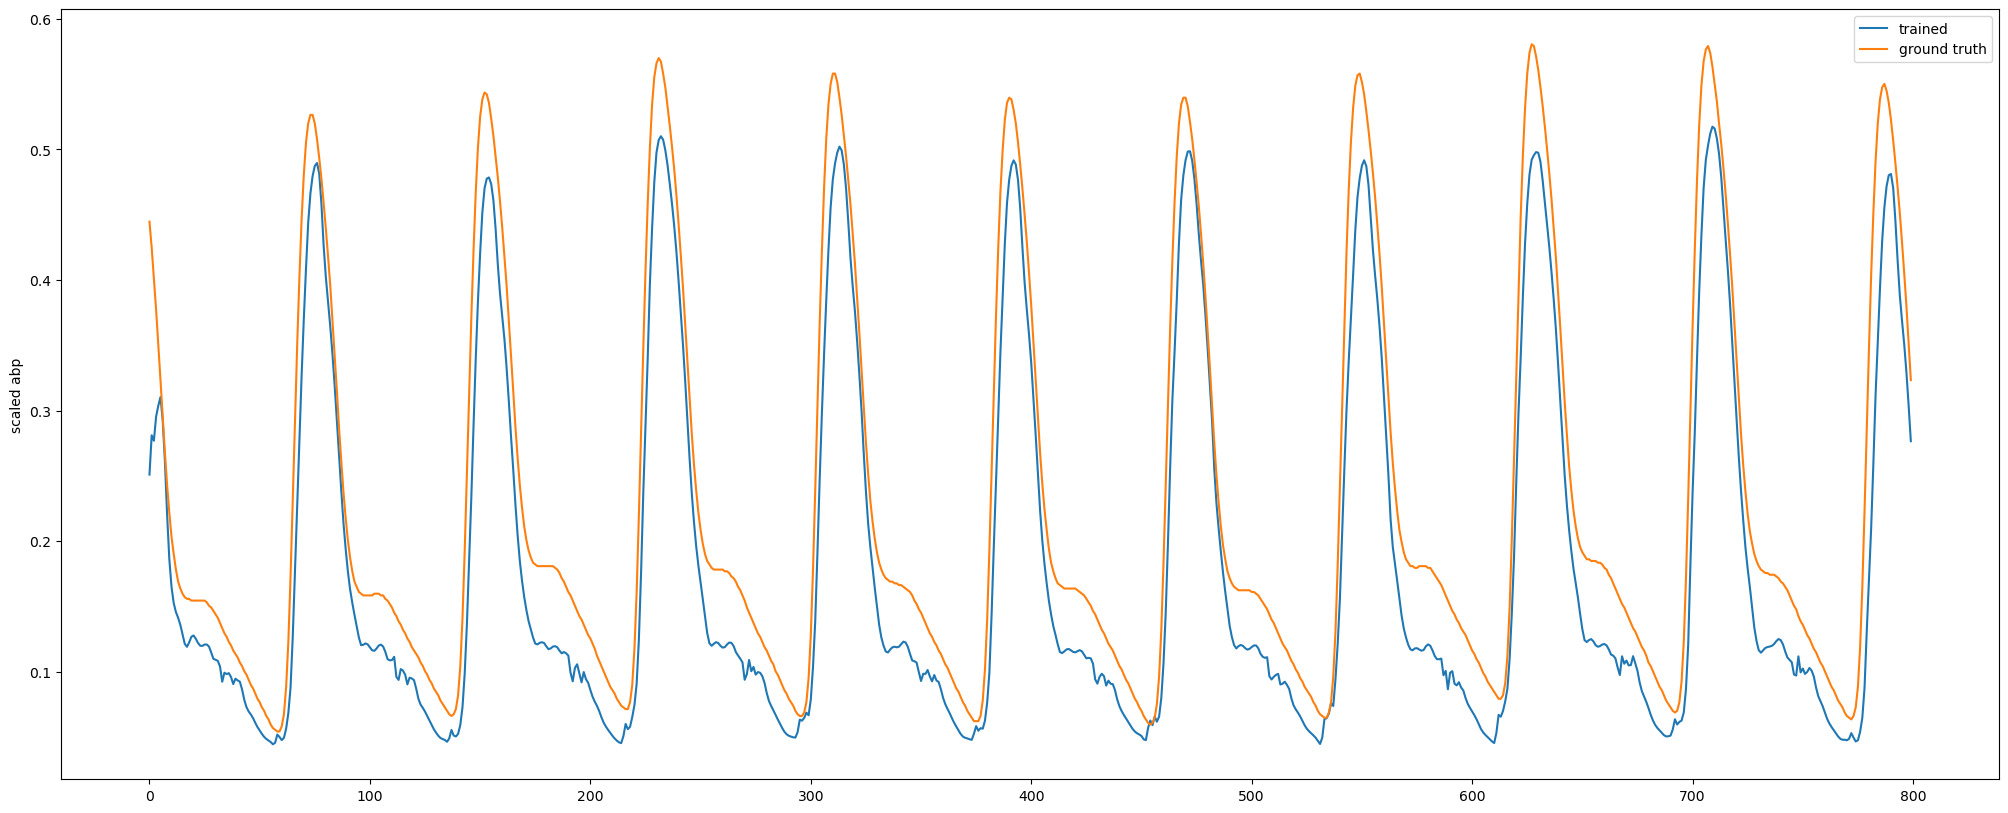

In [117]:
#plot and compare to the grond truth
plt.rcParams['figure.figsize'] = [25, 10]
plt.plot(output_trained_1d[0:800], label='trained')
plt.plot(abp_train_conv_scaled[0:800], label='ground truth')
plt.ylabel('scaled abp')
plt.legend()

It can be seen that the trained model is able to predict the training data well. Now we're going to use the trained model to predict the **test data**.

In [124]:
ppg_test_conv = convert_to_2d(X_test, 0)
ecg_test_conv = convert_to_2d(X_test, 1)
abp_test_conv = convert_to_2d(y_test)

ppg_test_conv_scaled = (ppg_test_conv - ppg_test_conv.min())/(ppg_test_conv.max()-ppg_test_conv.min())
ecg_test_conv_scaled = (ecg_test_conv - ecg_test_conv.min())/(ecg_test_conv.max()-ecg_test_conv.min())
abp_test_conv_scaled = (abp_test_conv - abp_test_conv.min())/(abp_test_conv.max()-abp_test_conv.min())

#convert to time series
ppg_test_timeseries_scaled = convert_to_timeseries(ppg_test_conv_scaled, 32)
ecg_test_timeseries_scaled = convert_to_timeseries(ecg_test_conv_scaled, 32)
abp_test_timeseries_scaled = convert_to_timeseries(abp_test_conv_scaled, 32)

#put ppg and ecg together to form the encoder input with shape (201554,32,2)
encoder_input_test = np.stack((ppg_test_timeseries_scaled, ecg_test_timeseries_scaled), axis=2)
#stacl abp as well to form the decoder output with shape (201554,32,1)
decoder_output_test = np.expand_dims(abp_test_timeseries_scaled, axis=2)

In [126]:
#predict the abp with the encoder input test
output_test = model_trained(torch.from_numpy(encoder_input_test[0:1280]).to(device).float())

In [130]:
#convert the output to 1d
output_test_1d = convert_to_1d(output_test.cpu().detach().numpy())
output_test_1d.shape

(1311,)

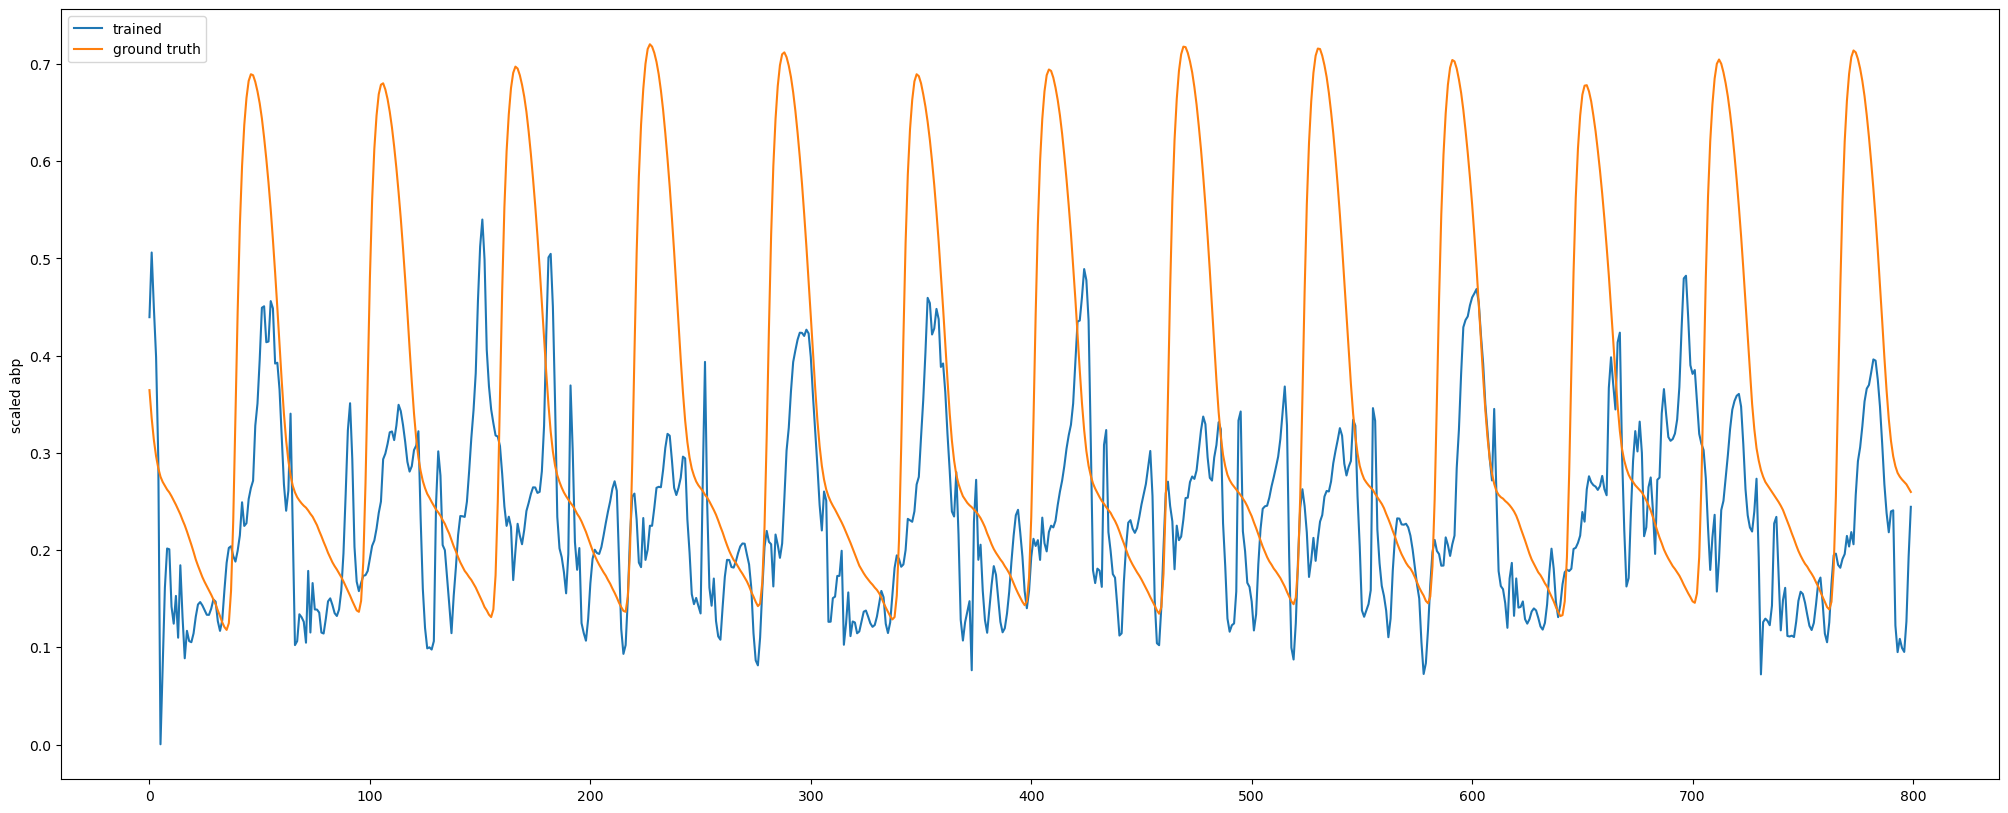

In [131]:
#plot the predicted abp and the ground truth
plt.rcParams['figure.figsize'] = [25, 10]
plt.plot(output_test_1d[0:800], label='trained')
plt.plot(abp_test_conv_scaled[0:800], label='ground truth')
plt.ylabel('scaled abp')
plt.legend()


Unfortunately the test data prediction is shit. That make sense though, since this is just a training demo. Maybe the model is overfitted, we gotta put more work into the training process.

# ------------------------------------------------------------